In [19]:
import os
# import shutil
import utilities as rocku
import matplotlib.pyplot as plt
# import tomopy
import numpy as np
# import pandas as pd
import pprint
import dxchange
import multiprocessing as mp
import timeit
from skimage import transform, io, exposure
from pystackreg import StackReg
import pystackreg
import skimage as ski

In [2]:
ncore = mp.cpu_count()
ncore

48

In [3]:
# need to change
ipts="26647"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
# scan_type = 'processed_data'

In [7]:
def composite_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

def overlay_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = np.stack(imgs, axis=0)

    return aggregator(imgs, axis=0)

def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])

In [4]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/analysis"# + scan_type
folder_list = os.listdir(scan_loc)
folder_list.sort()
folder_list

['2021_05_26_DOE_print',
 '2022_04_15_Monalisa',
 '2022_04_22_Monalisa_G0',
 '2022_04_22_Monalisa_G0_no_loop',
 '2022_04_23_Monalisa_G1_loop_400nm',
 '2022_04_24_Monalisa_G0_loop_12steps',
 '2022_04_24_Monalisa_G0_loop_14steps',
 '2022_04_25_Monalisa_G0_loop_14steps_16mm',
 '2022_04_25_Monalisa_G1_loop_400nm_16mm',
 '2022_04_26_Coin_French',
 '2022_04_26_Coin_US',
 '2022_04_26_Ti64',
 '2022_04_26_bent_screws',
 '2022_04_26_quartz_tube',
 '2022_04_27_AM_gradient',
 '2022_04_27_Ti64_pores',
 '2022_04_27_Ti64_stepping',
 '2022_04_27_electrodes_Han',
 '2022_04_27_electrodes_Nelson',
 '2022_04_28_DOE_angles',
 '2022_04_28_paper',
 '2022_04_28_polymer',
 '2022_04_29_DOE_CT_DFI-1.png',
 '2022_04_29_DOE_CT_DFI.avi',
 '2022_04_29_DOE_CT_DFI.gif',
 '2022_04_29_DOE_CT_TI-1.png',
 '2022_04_29_DOE_CT_TI.avi',
 '2022_04_29_DOE_CT_TI.gif',
 '2022_04_29_DOE_angles',
 '2022_04_29_Monalisa_angles',
 '2022_04_29_Monalisa_angles_DFI.gif',
 '2022_04_29_Monalisa_angles_TI.gif',
 '2022_04_29_concrete',
 '202

In [5]:
sample_name = "2023_06_15_weld"
scan_dir = os.path.join(scan_loc, sample_name)
fname_list = os.listdir(scan_dir)
fname_list.sort()
# name_pattern = None
# name_pattern = "DFI_ACL"
name_pattern = "TI_ACL"
fname_list_ft = rocku.filter_list(fname_list, name_pattern)
fname_list_ft.sort(reverse=True)
fname_list_ft

['TI_ACL_197.fits',
 'TI_ACL_192.fits',
 'TI_ACL_187.fits',
 'TI_ACL_182.fits',
 'TI_ACL_177.fits',
 'TI_ACL_172.fits',
 'TI_ACL_167.fits',
 'TI_ACL_162.fits',
 'TI_ACL_157.fits',
 'TI_ACL_152.fits',
 'TI_ACL_147.fits',
 'TI_ACL_142.fits',
 'TI_ACL_137.fits',
 'TI_ACL_132.fits',
 'TI_ACL_127.fits',
 'TI_ACL_122.fits',
 'TI_ACL_117.fits',
 'TI_ACL_112.fits',
 'TI_ACL_107.fits',
 'TI_ACL_102.fits',
 'TI_ACL_097.fits',
 'TI_ACL_092.fits',
 'TI_ACL_087.fits',
 'TI_ACL_082.fits',
 'TI_ACL_077.fits',
 'TI_ACL_072.fits',
 'TI_ACL_067.fits',
 'TI_ACL_062.fits',
 'TI_ACL_057.fits',
 'TI_ACL_052.fits',
 'TI_ACL_047.fits',
 'TI_ACL_042.fits',
 'TI_ACL_037.fits',
 'TI_ACL_032.fits',
 'TI_ACL_027.fits',
 'TI_ACL_022.fits',
 'TI_ACL_017.fits',
 'TI_ACL_012.fits',
 'TI_ACL_007.fits',
 'TI_ACL_002.fits']

In [17]:
unreg = rocku.read_img_stack(scan_dir, fname_list_ft, flipud=True)

40it [00:02, 18.71it/s]


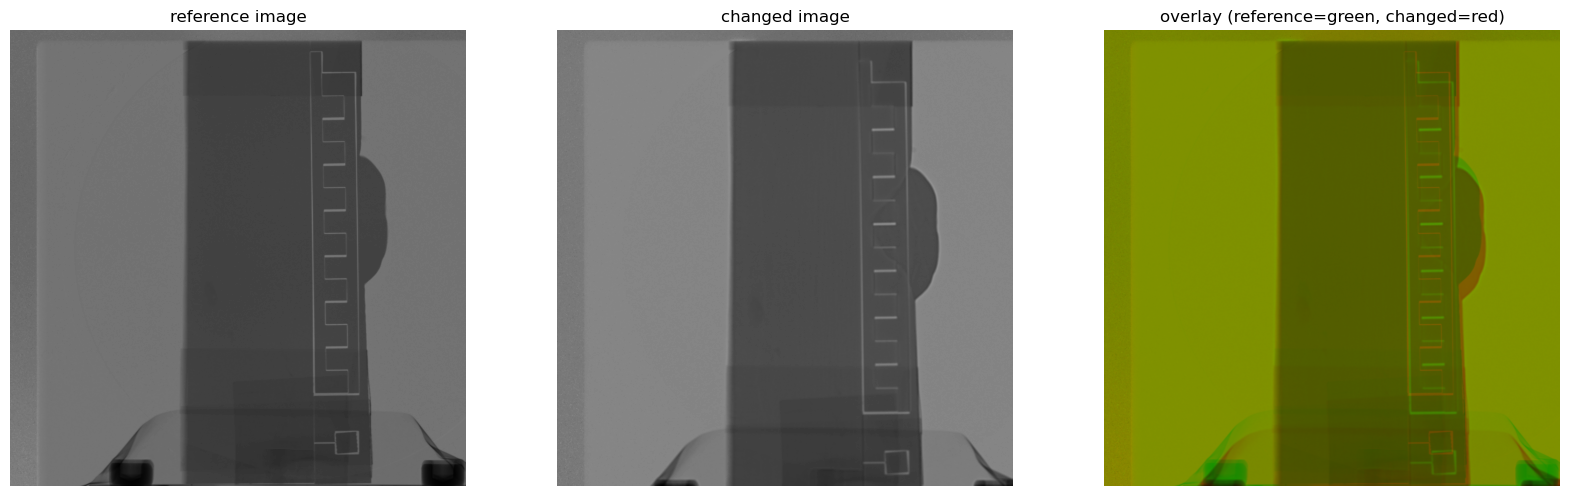

In [18]:
#load reference and "moved" image
ref = unreg[0]
mov = unreg[-1]
#########################
f, ax = plt.subplots(1, 3, figsize=(20, 9))
before_reg = composite_images([ref, mov])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(mov, cmap='gray')
ax[1].set_title('changed image')
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('overlay (reference=green, changed=red)')
ax[2].axis('off');

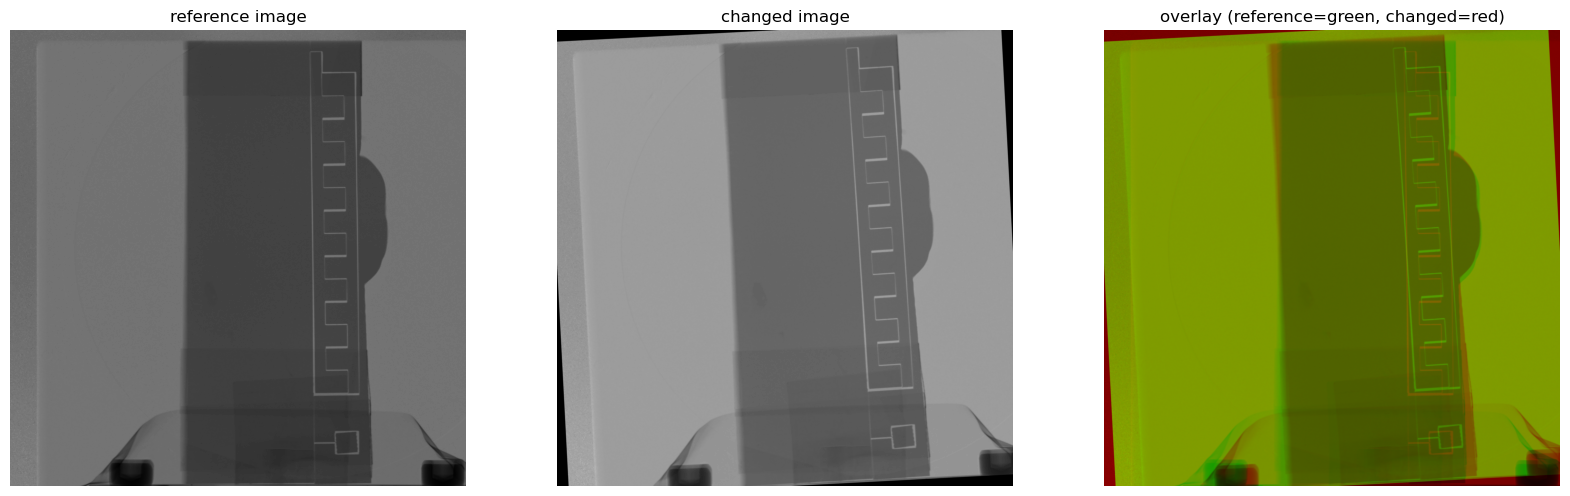

In [29]:
rot = ski.transform.rotate(ref, 3)
#########################
f, ax = plt.subplots(1, 3, figsize=(20, 9))
before_reg = composite_images([ref, rot])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(rot, cmap='gray')
ax[1].set_title('changed image')
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('overlay (reference=green, changed=red)')
ax[2].axis('off');

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2047 and the array at index 1 has size 1842

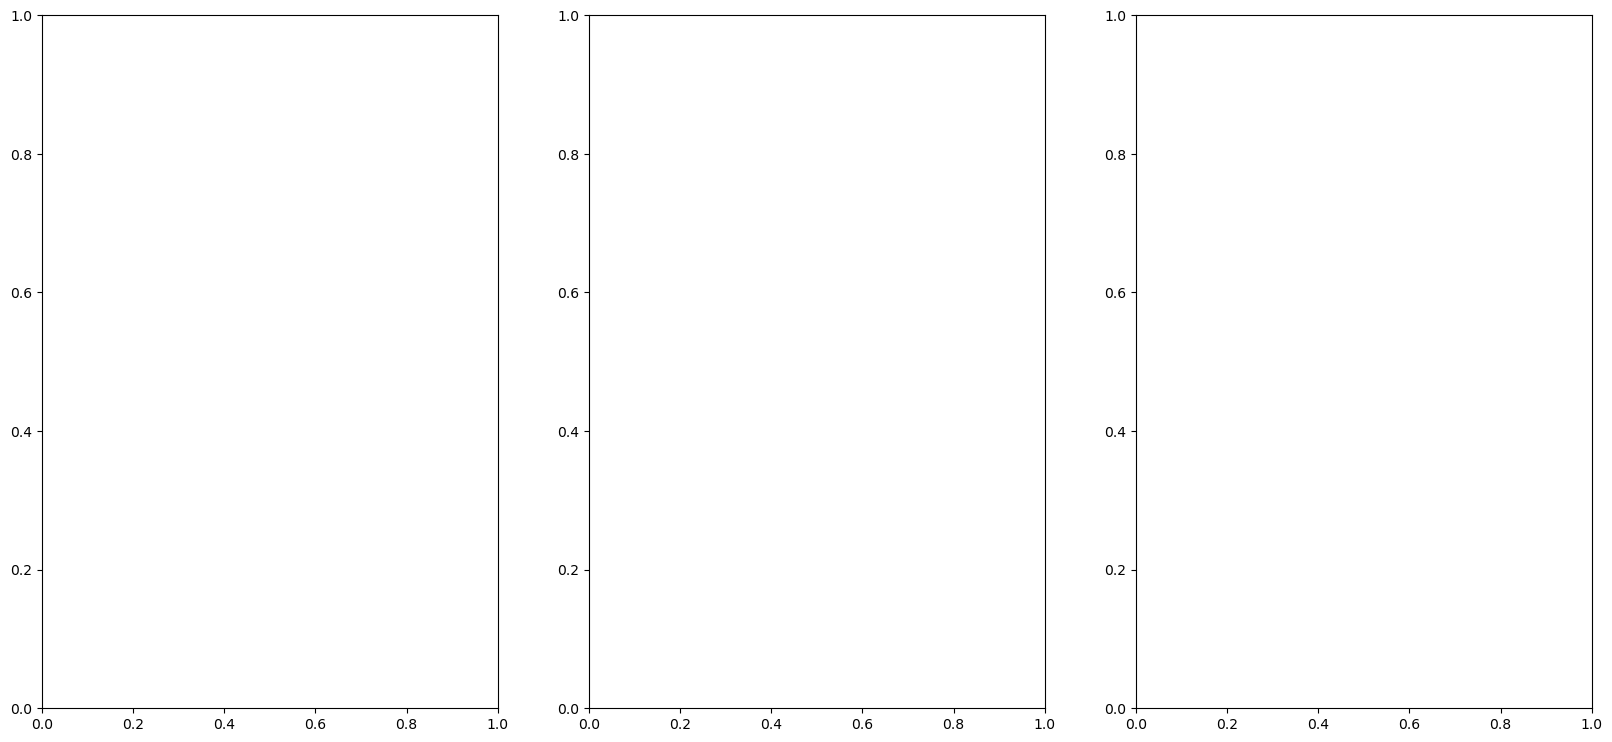

In [32]:
zoom = ski.transform.rescale(ref, 0.9)
#########################
f, ax = plt.subplots(1, 3, figsize=(20, 9))
before_reg = composite_images([ref, zoom])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(zoom, cmap='gray')
ax[1].set_title('changed image')
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('overlay (reference=green, changed=red)')
ax[2].axis('off');

In [ ]:
#########################
f, ax = plt.subplots(1, 3, figsize=(20, 9))
before_reg = composite_images([ref, mov])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(mov, cmap='gray')
ax[1].set_title('changed image')
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('overlay (reference=green, changed=red)')
ax[2].axis('off');

In [27]:
ref.shape

(2047, 2047)

In [26]:
img3.shape

(1024, 1024)

In [11]:
transformations = {
#     'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
#     'AFFINE': StackReg.AFFINE,
#     'BILINEAR': StackReg.BILINEAR
}

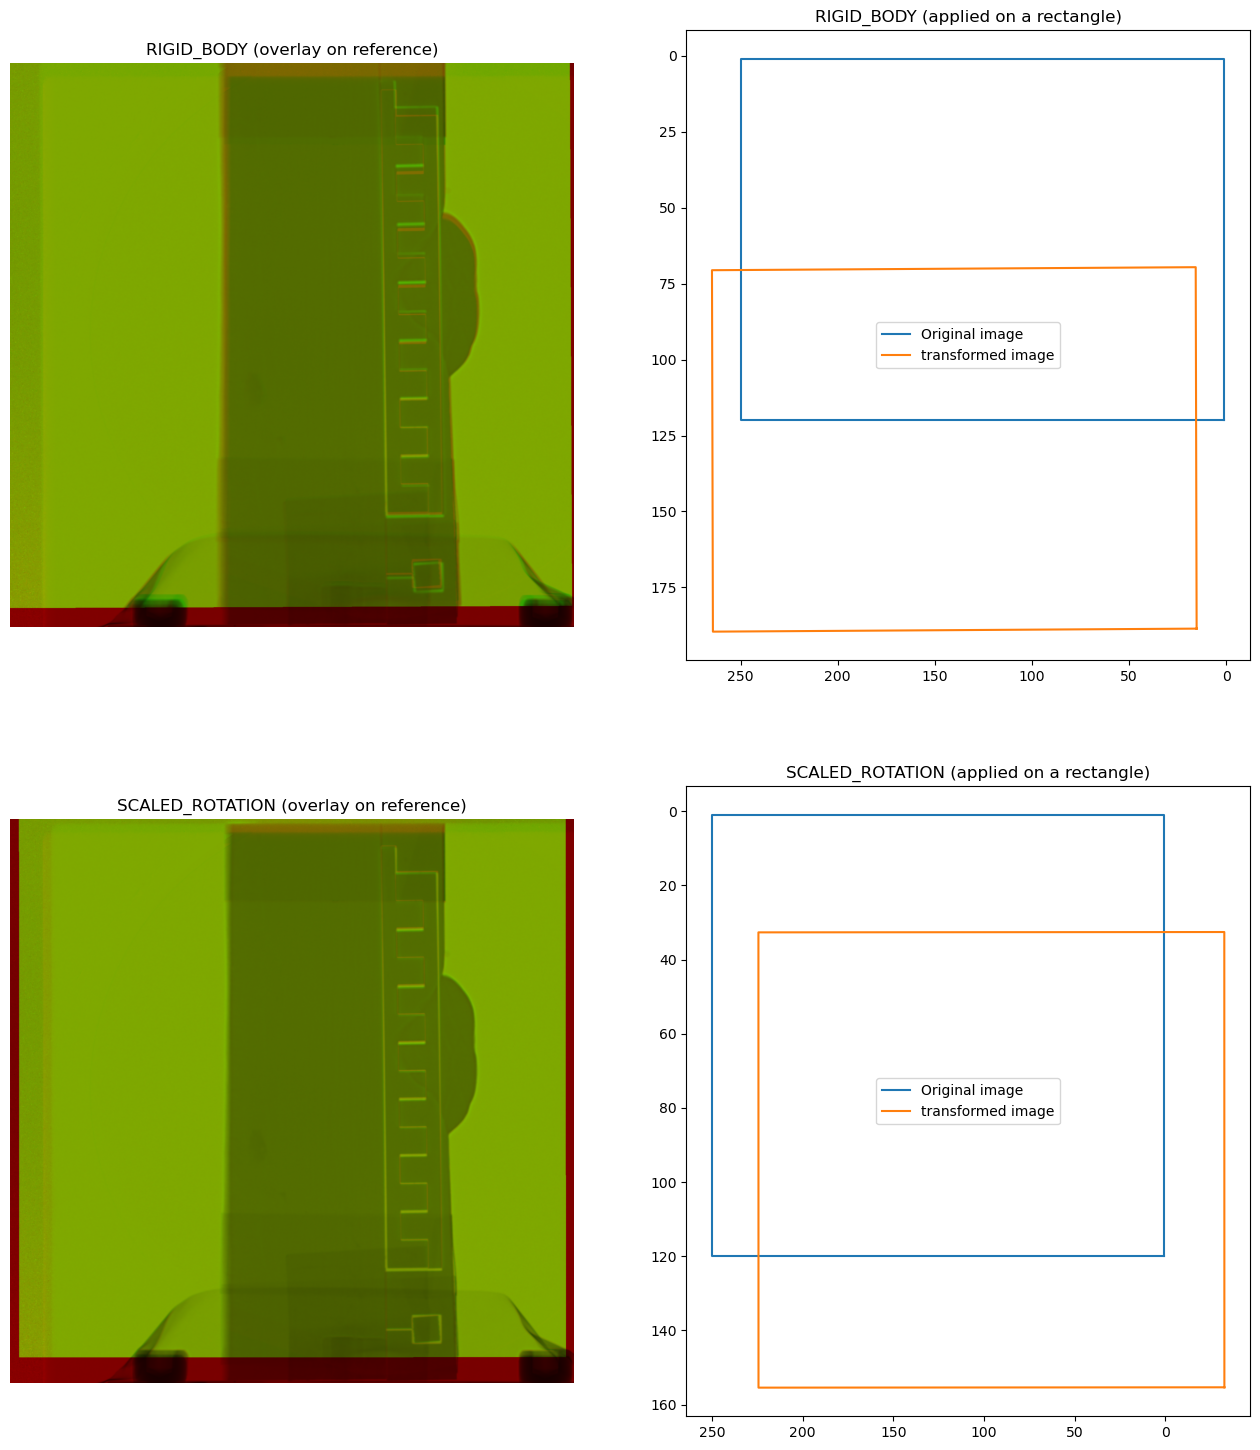

In [12]:
f, ax = plt.subplots(len(transformations), 2, figsize=(16, 18))

for i, (name, tf) in enumerate(transformations.items()):
    sr = StackReg(tf)
    reg = sr.register_transform(ref, mov)
    reg = reg.clip(min=0)

    after_reg =  composite_images([ref, reg])

    ax[i][0].imshow(after_reg, cmap='gray', vmin=0, vmax=1)
    ax[i][0].set_title(name + ' (overlay on reference)')
    ax[i][0].axis('off')

    if name != 'BILINEAR':
        show_transformation(sr.get_matrix(), ax[i][1])
        ax[i][1].set_title(name + ' (applied on a rectangle)')
    else:
        ax[i][1].axis('off')

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [04:44<00:00,  7.30s/it]


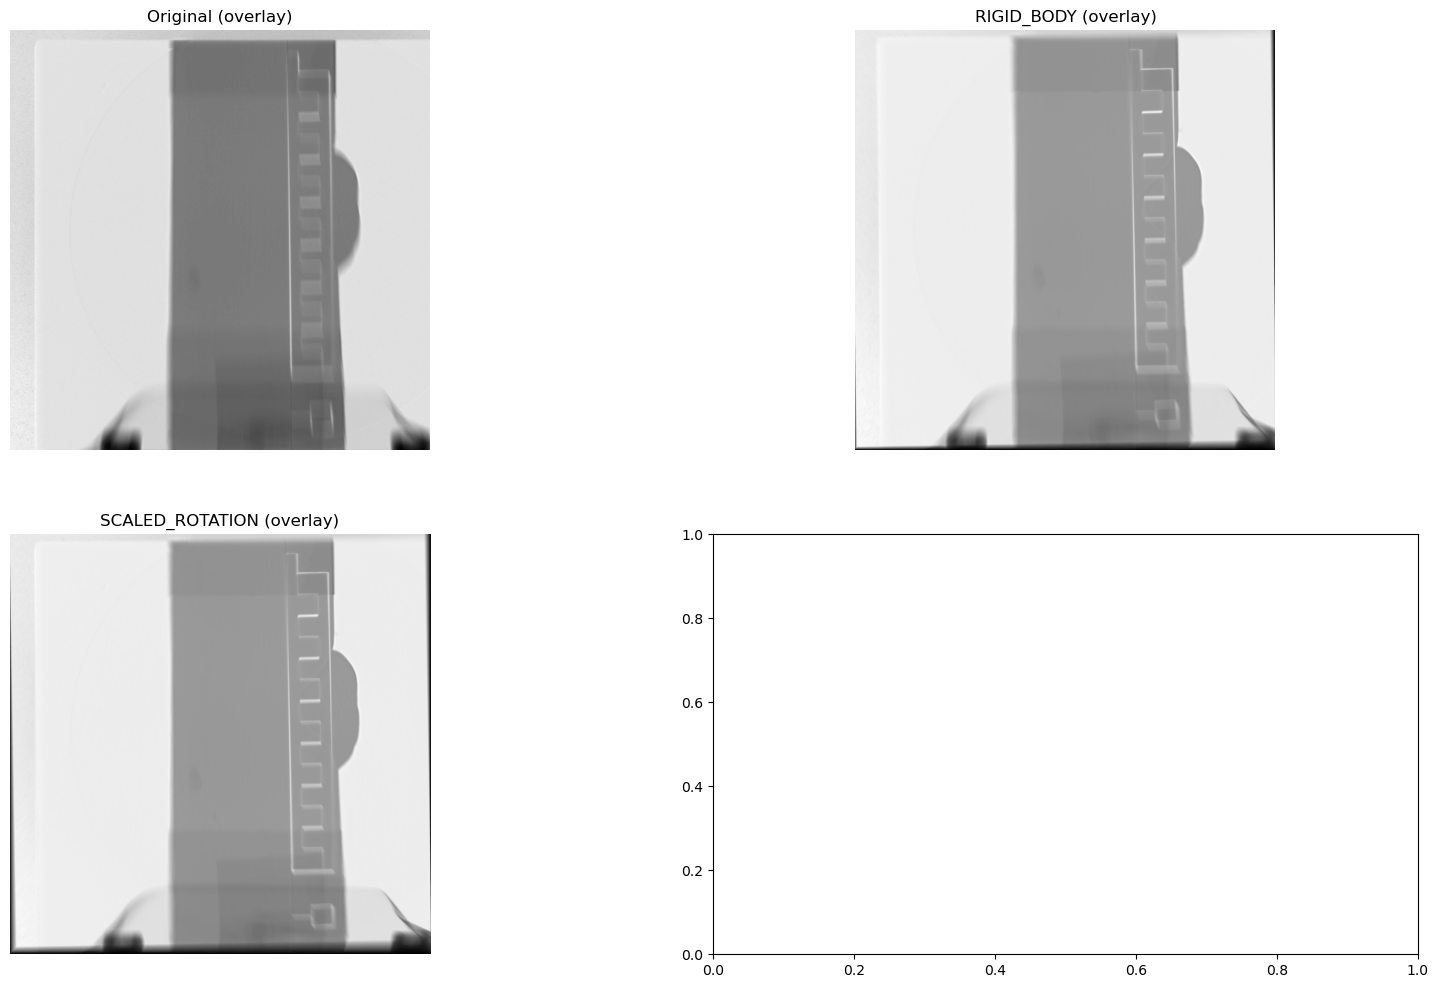

In [13]:
f, ax = plt.subplots(2, int(np.ceil((len(transformations)+1)/2)), figsize=(20, 12))
ax = ax.ravel()

ax[0].imshow(overlay_images(unreg, aggregator=np.mean), cmap='gray')
ax[0].set_title('Original (overlay)')
ax[0].axis('off')

# store transformation matrices for later use in this variable
tmats = []
reg_dict = {}
tmat_dict = {}

for i, (name, tf) in enumerate(transformations.items()):
    sr = StackReg(tf)

    reference = 'first' if name == 'BILINEAR' else 'previous'

    tmat = sr.register_stack(unreg, axis=0, reference=reference, verbose=True)
    reg = sr.transform_stack(unreg)
    reg_dict[name] = reg
    tmat_dict[name] = tmat
    tmats.append(tmat)

    ax[i+1].imshow(overlay_images(reg, aggregator=np.mean), cmap='gray')
    ax[i+1].set_title(name + ' (overlay)')
    ax[i+1].axis('off')

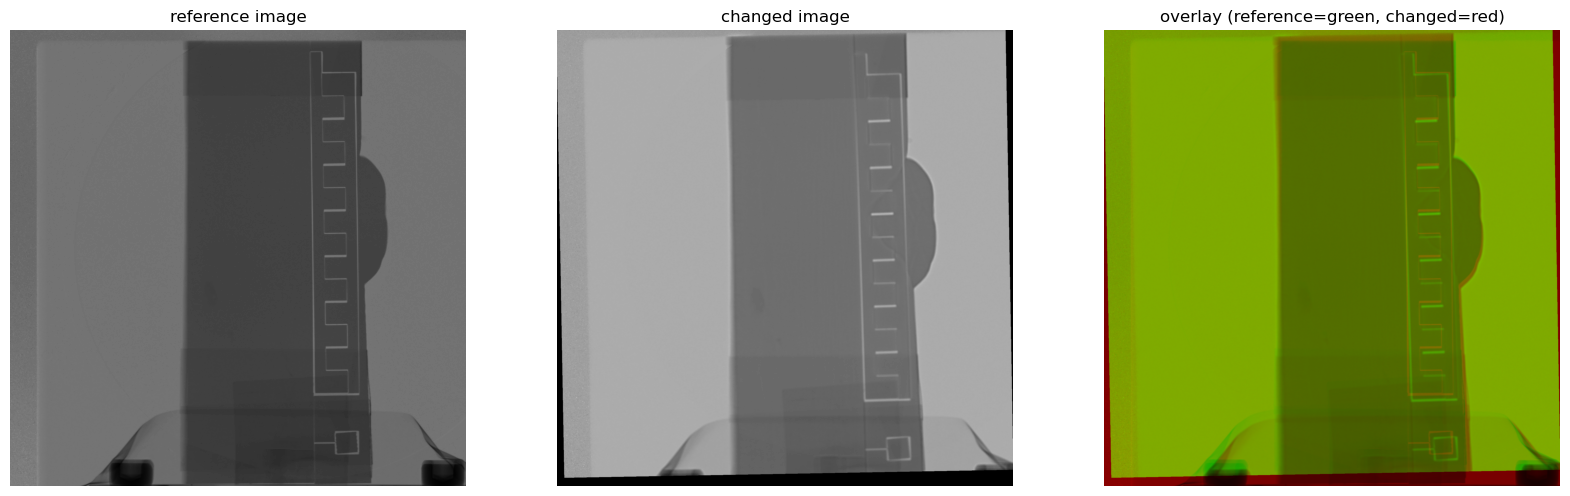

In [16]:
f, ax = plt.subplots(1, 3, figsize=(20, 9))
# trans = 'BILINEAR'
# trans = 'AFFINE'
trans = 'SCALED_ROTATION'
# trans = 'RIGID_BODY'
# trans = 'TRANSLATION'
img0 = reg_dict[trans][0]
img1 = reg_dict[trans][-1]
composite = composite_images([img0, img1])

ax[0].imshow(img0, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(img1, cmap='gray')
ax[1].set_title('changed image')
ax[1].axis('off')

ax[2].imshow(composite)
ax[2].set_title('overlay (reference=green, changed=red)')
ax[2].axis('off');

# Save files

In [67]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/analysis/results/" + sample_name
for e_key in reg_dict.keys():
    for i, e_name in enumerate(fname_list_ft):
    #     e_name = rocku.remove_1st_str(e_name)
#         fname = save_to + "_" + e_key + "/" + e_name
#         fname = save_to + "_" + e_key + "/" + e_name.split('.')[0] + '.tiff'
        fname = save_to + "_" + e_key + "/" + e_name.split('.')[0]
        print('Saving to {} ...'.format(fname))
#         io.imsave(fname=fname, arr=reg_dict[e_key][i], plugin='fits')
#         io.imsave(fname=fname, arr=reg_dict[e_key][i], plugin='tifffile')
        dxchange.write_tiff(np.array(reg_dict[e_key][i]), fname=fname, overwrite=True)
# dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)
# print('Combining with median ...')
# scan_med = np.median(scan_norm, axis=0)
# print(scan_med.dtype)
# dxchange.write_tiff(scan_med, fname=save_to + "/MED", overwrite=True)
# dxchange.write_tiff(ob_med, fname=save_to + "/OB_DC", overwrite=True)
# dxchange.write_tiff(dc_med, fname=save_to + "/DC", overwrite=True)

Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_197 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_192 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_187 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_182 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_177 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_172 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_167 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_162 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_SCALED_ROTATION/TI_ACL_157 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_S

Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_177 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_172 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_167 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_162 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_157 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_152 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_147 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_142 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_137 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/analysis/results/2023_06_15_weld_BILINEAR/TI_ACL_132 ...
Saving to /HFIR/CG1D/IPTS-26647/shared/a

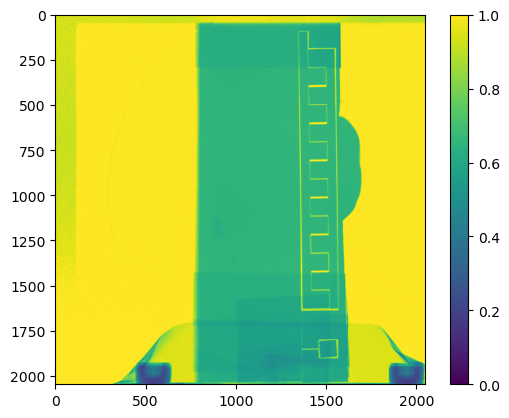

In [23]:
plt.imshow(reg_dict['AFFINE'][0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

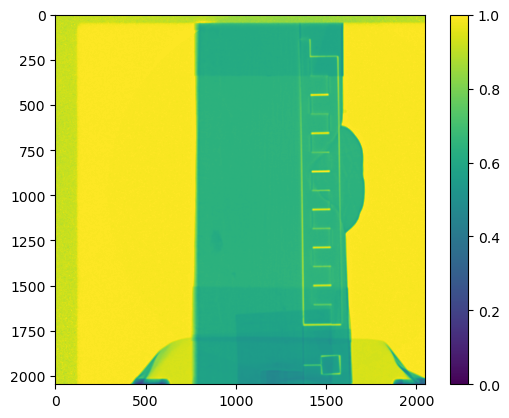

In [24]:
plt.imshow(mov, vmin=0, vmax=1)
plt.colorbar()
plt.show()

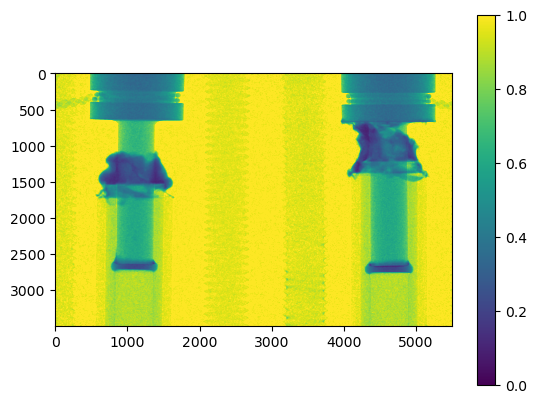

In [8]:
plt.imshow(raw[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

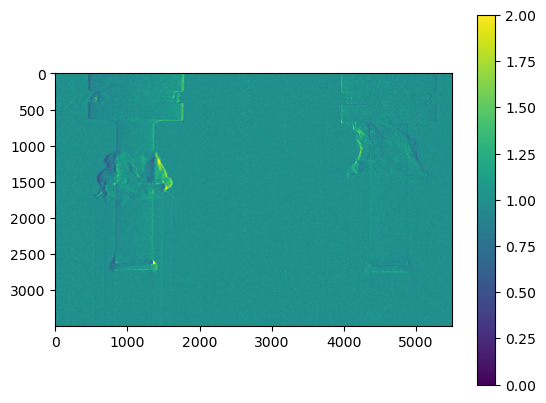

In [9]:
plt.imshow(raw[-1]/raw[0], vmin=0, vmax=2)
plt.colorbar()
plt.show()

Alignment ROI:


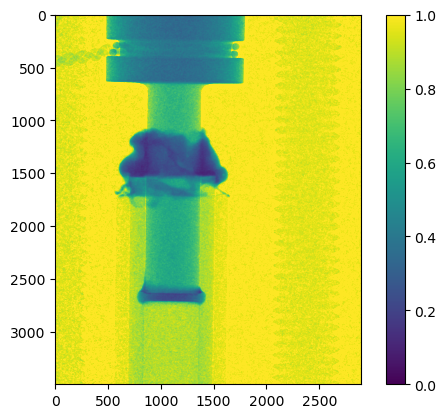

In [10]:
###################### need to change start
roi = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
roi_left = 0
roi_right = 2900
roi_top = 0
roi_bottom = 3500
###################### need to change end
raw_roi = rocku.crop(raw, roi_left, roi_right, roi_top, roi_bottom, roi)
# moved_roi = rocku.crop(moved, roi_left, roi_right, roi_top, roi_bottom, roi)
print("Alignment ROI:")
plt.imshow(raw_roi[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
# crop_roi_dict = {
#     'left': crop_left,
#     'right': crop_right,
#     'top': crop_top,
#     'bottom': crop_bottom
# }

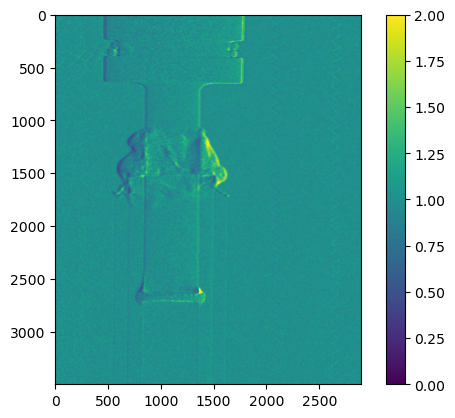

In [16]:
plt.imshow(raw_roi[-1]/raw_roi[0], vmin=0, vmax=2)
plt.colorbar()
plt.show()

In [24]:
tform = ski.transform.estimate_transform('similarity', raw_roi[-1], raw_roi[0])

In [26]:
tform.params

array([[ 1.87712458e-01, -1.83483860e-02,  6.40226075e-04, ...,
        -7.10592174e-03,  5.69090249e-04,  4.51904131e-01],
       [-3.00847490e-02,  2.17328814e-01, -1.99417711e-02, ...,
        -4.87158724e-04,  9.73349080e-03, -1.32216059e+00],
       [-1.14917770e-02, -2.26340323e-02,  2.18584359e-01, ...,
        -5.41176990e-04,  3.22125771e-02, -5.92966588e-01],
       ...,
       [ 3.45180039e-02, -1.61551684e-02, -1.55748098e-02, ...,
         2.00779425e-01, -1.16429413e-02,  1.25707066e+00],
       [ 1.59576568e-02, -1.33739059e-02, -1.96185394e-02, ...,
        -1.42403634e-02,  2.31260798e-01,  4.65773719e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [27]:
tform.dimensionality

2900

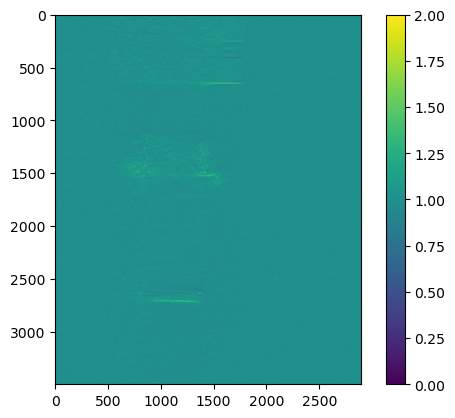

In [32]:
plt.imshow(tform(raw_roi[-1])/raw_roi[0],vmin=0, vmax=2)
plt.colorbar()
plt.show()

In [14]:
import TXM_Sandbox.utils.reg_algs as regu
import skimage as ski

In [43]:
regu.cost_norm(stk_roi[0], stk_roi[1], type='tv')

0.007282811691857582

In [47]:
regu.cost_norm(stk_roi[0], stk_roi[1], type='de')

0.003932745619749366

In [48]:
regu.cost_abs(stk_roi[0], stk_roi[1], type='de')

39972.42

In [50]:
regu.cost_abs(stk_roi[0], stk_roi[1], type='tv')

80377.8039880991

In [17]:
flow = ski.registration.optical_flow_tvl1(raw_roi[0], raw_roi[1])

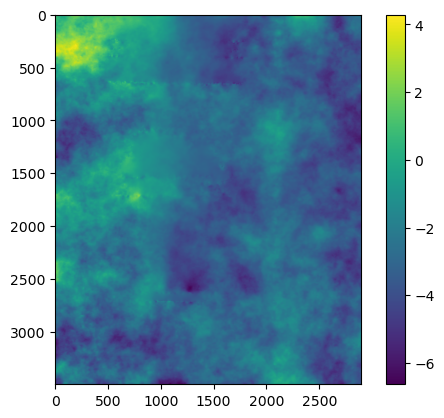

In [21]:
plt.imshow(flow[0])
plt.colorbar()
plt.show()

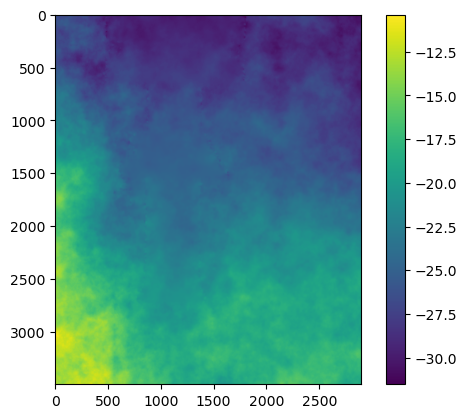

In [22]:
plt.imshow(flow[1])
plt.colorbar()
plt.show()

In [46]:
regu.reg_stack(stk_roi,"MRTV_REG")

NameError: name 'mp' is not defined